***
<font size="2.5" color="#008385">15-288: Machine Learning in a Nutshell, *CMU-Qatar,* Spring'24<br><p></font>
    
<font size="+4" color="#008385"> **Team 1:** Asian Faces Classification using Machine Learning </font>   
<br><p>
<center><font size="+2.9" color="red">Presented by Phat Diep (phdiep), Sangyoon Lim (sangyoon)</font></center>

***

## <font color="blue">D2.1a Data Directory </font>



In [6]:
import os
from pathlib import Path

#Establish base directory for image processing
base_dir = os.getcwd()  # Default to current working directory

# Define source directories containing images from different regions
source_dirs = [
    os.path.join(base_dir,"data - Copy","Vietnam"),
    os.path.join(base_dir,"data - Copy","China"),
    os.path.join(base_dir,"data - Copy","Japan"),
    os.path.join(base_dir,"data - Copy","Korea"),
    os.path.join(base_dir,"data - Copy","Phillipines")
]

## <font color="blue">D2.1b Data Collection: Custom dataset </font>

This section involves scraping images from the Internet using SerpAPI based on specific search queries.

The code handles API interactions, error management, and saves the images in a local directory.

Here are some queries' keywords that we chose:

* [China,Japan,Korea,Phillipine,Vietnam] Linkedin Female
* [Korean] female celebrity = 여자 연예인 증명사진
* [Japan] female = 日本人女性の髪型

Since the cap for free API is 100 searches/account. We have to register new accounts for each time this code reaches maximum. **Total accounts used: 6**

The output is store in a corresponding country directory

In [5]:
from serpapi import GoogleSearch
import os, json
import time
import urllib.request  # Import urllib for downloading images
os.makedirs("Japan") # Create directory for storing images

def download_image(api, img_search, n):
    '''
    Input: API key, search keywords, and number of images per page
    Output: Store Images in a directory (e.g. Japan) 
    '''
    image_results = []
    
    # Search query parameters setup
    params = {
        "engine": "google",               # Specify the search engine
        "q": img_search,                  # Define the search query
        "tbm": "isch",                    # Specify the type of search results (image search)
        "num": n,                         # Number of images per page
        "ijn": 0,                         # Page number: 0 -> first page
        "api_key": api                    # SerpAPI key
    }
    search = GoogleSearch(params)         # Initialize the search
    images_is_present = True
    while images_is_present:
        results = search.get_dict()       # Convert JSON results to Python dictionary
        if "error" not in results:
            for image in results["images_results"]:
                if image["original"] not in image_results:
                    image_results.append(image["original"])  # Store unique images only
            params["ijn"] += 1  # Move to the next page of results
        else:
            images_is_present = False
            print(results["error"])
    
    for index, image in enumerate(image_results, start=1):
        print(f"Downloading {index} image...")
        opener = urllib.request.build_opener()
        opener.addheaders = [("User-Agent", "Mozilla/5.0")]
        urllib.request.install_opener(opener)
        time.sleep(5)  # Delay to manage API call rate
        try:
            # Save the downloaded image to the specified directory with a formatted name
            urllib.request.urlretrieve(image, f"Japan/original_size_img_{index}.jpg")
        except Exception as e:
            print(f"Failed to download image {index}: {e}")
            continue



In [6]:
download_image("a9796c9f730d66ebaac3ff619a474eee423255aaabd35a9f9e9dd6582efa1c72",
                "日本人女性の髪型",
                100)

Google Images hasn't returned any results for this query.
Failed to download image 98: HTTP Error 403: Forbidden
Failed to download image 129: Remote end closed connection without response
Failed to download image 159: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
Failed to download image 219: HTTP Error 403: Forbidden
Failed to download image 248: HTTP Error 400: Bad Request
Failed to download image 251: HTTP Error 403: Forbidden
Failed to download image 288: HTTP Error 403: Forbidden
Failed to download image 290: HTTP Error 403: Forbidden
Failed to download image 293: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'en.photolibrary.jp'. (_ssl.c:1002)>
Failed to download image 317: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate ver

## <font color="blue">D2.1c Data Rename </font>

This section is designed to rename image files based on their creation time and copy them to a new directory. This allow us to **store images without replacement** between 2 subsequent downloads (Korea Linkedin Female and Korean Female Celebrity, they potientially share the same filename "Korea.jpg")

The renaming convention includes a sequential number which makes it easier to identify and sort images systematically.



In [9]:
import os
import shutil
from datetime import datetime

# Define the directory containing the images
directory = r"C:\Users\Phat Diep\Downloads\data\ML project 2\train\Korea"

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

# Sort the image files by creation time
image_files.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)))

# Create a new directory to store the renamed images
new_directory = os.path.join(directory, 'Renamed_Images')
if not os.path.exists(new_directory):
    os.makedirs(new_directory)

# Rename and copy the images to the new directory
for i, image_file in enumerate(image_files):
    timestamp = datetime.fromtimestamp(os.path.getctime(os.path.join(directory, image_file)))
    new_filename = str(i+1).zfill(4) + os.path.splitext(image_file)[1]
    new_filepath = os.path.join(new_directory, new_filename)
    shutil.copyfile(os.path.join(directory, image_file), new_filepath)

print('Images have been renamed and copied to:', new_directory)


Images have been renamed and copied to: C:\Users\Phat Diep\Downloads\data\ML project 2\train\Korea\Renamed_Images


## <font color="blue">D2.1d Extracting Face from Images</font>

This section processes the images by extracting faces using **<font color="blue">OpenCV's Haar cascade classifier.</font>**

**<font color="blue"> About Haar Cascade: </font>** "Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, Haar features shown in the below image are used. They are just like our **convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle**." (OpenCV, 2024)

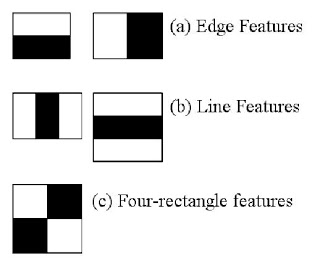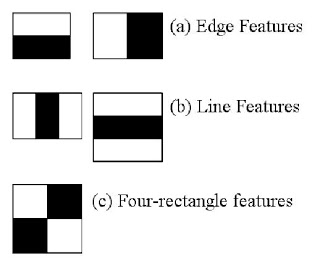

Extracted faces are saved in a designated subdirectory, aiding in focusing on relevant data for facial recognition tasks.

In [5]:
import cv2
import sys
import os

cascade_path = os.path.join(os.getcwd(),"cv2/haarcascade_frontalface_default.xml")

# Iterate through the files in the input directory
for source_dir in source_dirs:
    faces_dir = os.path.join(source_dir, 'faces')
    if not os.path.exists(faces_dir):
        os.makedirs(faces_dir)
    for file in os.listdir(source_dir):
        file_name, file_extension = os.path.splitext(file)
        path = os.path.join(source_dir,file)
        image = cv2.imread(path)
        if image is None:
            print("Error reading image:", path)
            continue
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Load the face detection cascade classifier
        faceCascade = cv2.CascadeClassifier(cascade_path)
        # Detect faces in the grayscale image
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.3,
            minNeighbors=3,
            minSize=(30, 30)
        )
        c = 0
        for (x, y, w, h) in faces:
            roi_color = image[y:y + h, x:x + w]
            output_filename = f"{file_name}_face_{c}{file_extension.lower()}"
            output_path = os.path.join(faces_dir, output_filename)
            print(f"Saving face: {output_path}")
            cv2.imwrite(output_path, roi_color)
            c+=1

Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\001_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\002_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\003_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\004_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\005_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\006_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\007_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\008_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\009_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\010_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\011_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vietnam\faces\012_face_0.jpg
Saving face: c:\Users\Phat Diep\Desktop\26_4_2024\Vi

## <font color="blue">D2.2 Data Analysis </font>

In [12]:
import os
config = {'image_size' :(128,128)}
base_dir = os.path.join(os.getcwd(),"data")

In [25]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_and_preprocess_dataset(base_dir, target_size):
    images = []
    labels = []
    label_dirs = [os.path.join(base_dir, label) for label in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, label))]
    for label in label_dirs:
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
                if img is not None:
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)
    return images,labels

### <font color="blue"> D2.2.1 Images Shape </font>

In [39]:
from sklearn.preprocessing import LabelEncoder
import cv2

images, labels = load_and_preprocess_dataset(base_dir,config['image_size'])
X_rgb = np.array(images).astype(int)

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
Y = np.array(labels_encoded) # Create label value

print(X_rgb.shape)
print(Y.shape)

(6456, 128, 128)
(6456,)


### <font color="blue"> D2.2.2 Check NaN in the dataset </font>

In [31]:
import numpy as np

#check if we have a value that is NAN 
nan_images = np.isnan(X_rgb)
#calculate teh number of the it
num_nan_images = np.sum(nan_images)
#calculate the number of NANs in the label 
nan_labels = np.isnan(Y)
num_nan_labels = np.sum(nan_labels)


if num_nan_images == 0:
    print("No NaN entries in images")
else:
    print("NaN entries are there ")

if num_nan_labels == 0:
    print("No NaN entries in labels")
else:
    print("NaN entries there")


No NaN entries in images
No NaN entries in labels


### <font color="blue"> D2.2.3 Check if dataset is well-balanced</font>

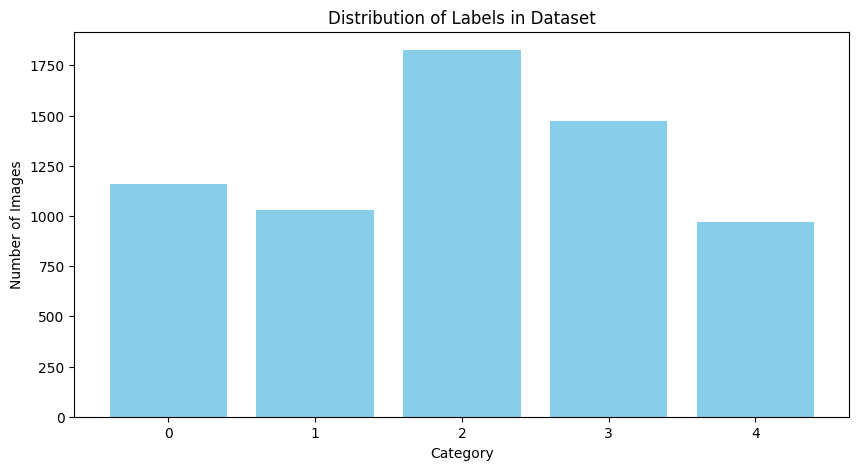

In [33]:
import matplotlib.pyplot as plt
import random
#use the bar chart to check if the dataset is well balanced depending on the label 
label_counts = np.bincount(Y)
num_categories = len(label_counts)
plt.figure(figsize=(10, 5))
plt.bar(range(num_categories), label_counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels in Dataset')
plt.xticks(range(num_categories))
plt.show()

### <font color="blue"> D2.2.4 Check if dataset is well-balanced</font>

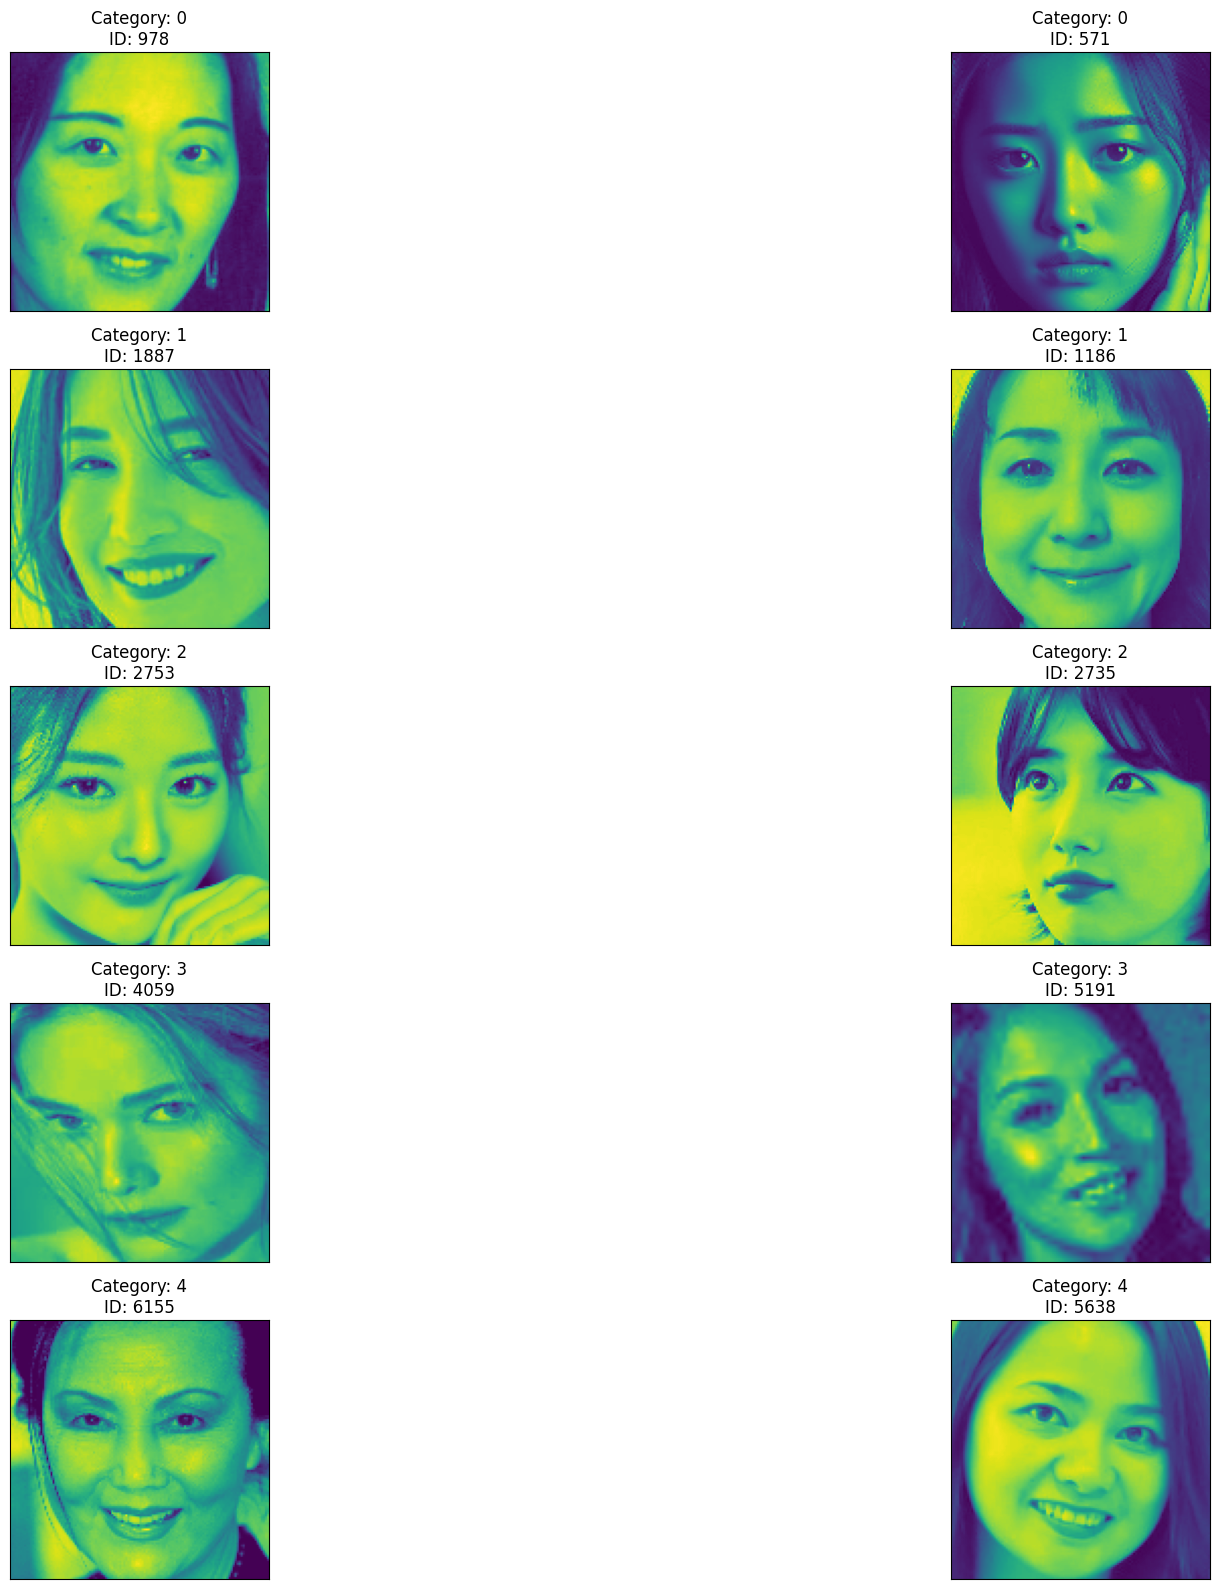

In [36]:
import random

#we have a function that chose the function that is randomly chosen 
def random_chosen(labels):
    random_indices = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        #add random indices to the array so we can use later on 
        random_indices.extend(random.sample(list(label_indices), min(2, len(label_indices))))
    return random_indices

#function that visualize the figures 
def visualize(images, labels, random_indices):
    plt.figure(figsize=(26, 16))
    for i, idx in enumerate(random_indices):
        label = labels[idx]
        #found out the most ideal way to visualize the images 
        plt.subplot(len(random_indices) // 2 + len(random_indices) % 1, 2, i+1)
        plt.imshow(images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Category: {label}\nID: {idx}")
    
    plt.tight_layout()
    plt.show()

#chose the random 5 values and the 
random_indices = random_chosen(Y)
visualize(X_rgb, Y, random_indices)

## <font color="blue">D2.3 Duplicate Removal and Training Data Preparation </font>

This section includes scripts for removing duplicate images based on structural similarity 

and preparing the training dataset by moving face images into training directories categorized by region.

In [7]:
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def remove_duplicates(folder_path):
    file_dict = {}
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            filepath = os.path.join(subdir, file)
            # Load the image in grayscale to speed up comparisons
            try:
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (100, 100))  # Resize to speed up comparison

                if img is not None:
                    key = tuple(img.flatten())
                    if key in file_dict:
                        os.remove(filepath)
                        print('Removed duplicate:', filepath)
                    else:
                        file_dict[key] = filepath
            except:
                print("read error")

for src_dir in source_dirs:
    remove_duplicates(src_dir)

## <font color="blue">D2.4 Move to a training dir </font>

In [9]:
face_dirs = [
    os.path.join(base_dir,"Vietnam","faces"),
    os.path.join(base_dir,"China","faces"),
    os.path.join(base_dir,"Japan","faces"),
    os.path.join(base_dir,"Korea","faces"),
    os.path.join(base_dir,"Phillipines","faces")
]

In [10]:
train_dirs = [
    os.path.join(base_dir,"train\Vietnam"),
    os.path.join(base_dir,"train\China"),
    os.path.join(base_dir,"train\Japan"),
    os.path.join(base_dir,"train\Korea"),
    os.path.join(base_dir,"train\Phillipines")
]

In [11]:
import os
import shutil

# Loop through each source directory and its corresponding target directory
for face_dir, train_dir in zip(face_dirs, train_dirs):
    # Ensure the target directory exists; create it if it doesn't
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)

    # Get a list of files in the source directory
    files = os.listdir(face_dir)

    # Copy each file from the source directory to the target directory
    for file_name in files:
        # Full path of the source file
        source_file = os.path.join(face_dir, file_name)
        # Full path of the destination file
        target_file = os.path.join(train_dir, file_name)

        # Check if it's a file (not a directory) and then copy it
        if os.path.isfile(source_file):
            shutil.copy2(source_file, target_file)  # Copy and preserve metadata


## <font color="blue"> And then we filter them by hand ;) </font>
**No Male, No Objects !**

In [8]:
import os
from PIL import Image

# Function to check if a file is an image
def is_image(file_path):
    try:
        # Try opening the file with PIL to confirm it's an image
        with Image.open(file_path) as img:
            return True
    except IOError:
        return False

# Function to count all images in a folder and its subfolders
def count_images(folder_path):
    image_count = 0
    # Traverse the folder and its subfolders
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            if is_image(file_path):
                # If the file is an image, increment the count
                image_count += 1
    return image_count

# Example usage
folder_path = r"C:\Users\Phat Diep\Desktop\final\new - Copy\data\train"  # Specified path
image_count = count_images(folder_path)
print(f"Total count of all images in the folder and its subfolders: {image_count}")


Total count of all images in the folder and its subfolders: 5125


## <font color="blue"> Split for training (No need, redundant) </font>
**Post-presentation improve**: I was making an inductive bias by splitting at this point **Next step:** Keep all in one directory and split them using by torch
<!-- * **20%** for test data
* **80%** for train data -->

In [1]:
# import random

# def split_and_move_images(source_dirs,destination_dir):
#     # Traverse through each source directory
#     for subdir in source_dirs:
#         # List all files in the directory
#         files = os.listdir(subdir)
        
#         # Filter for image files (this is basic; adjust as needed)
#         image_files = [f for f in files if f.lower().endswith(('.jpg'))]
        
#         # Create a test directory for the current folder
#         test_folder_name = os.path.join(destination_dir, f"{os.path.basename(subdir)}")
#         os.makedirs(test_folder_name, exist_ok=True)

#         # Determine the number of images to move (20% of the total)
#         num_images_to_move = int(len(image_files) * 0.2)

#         # Randomly select images to move
#         images_to_move = random.sample(image_files, num_images_to_move)

#         # Move selected images to the test folder
#         moved_count = 0
#         for image in images_to_move:
#             src_path = os.path.join(subdir, image)
#             dest_path = os.path.join(test_folder_name, image)
            
#             # Ensure the source file exists before moving
#             if os.path.isfile(src_path):
#                 shutil.move(src_path, dest_path)
#                 moved_count += 1
#             else:
#                 print(f"File '{src_path}' not found. Skipping...")

#         print(f"Moved {moved_count} images to '{test_folder_name}'.")

# destination_dir = r"C:\Users\Phat Diep\Desktop\26_4_2024\test"

# # Call the function to split and move images
# split_and_move_images(train_dirs,destination_dir)